
# 2021-05-17 Artems Qubit
## AY Cell Q2
> - 350µm cross
> - 110nm x 110nm JJ
> - 5.91 x 4.18 µm2 area
## AY Cell Q3
> - 350µm cross
> - 120nm x 120nm JJ
> - 5.91 x 4.25 µm2 area
## Ay Cell Q4
> - 350µm cross
> - 130nm x 130nm JJ
> - 5.9 x 4.06 µm2 area

In [2]:
%matplotlib notebook
import logging
from typing import List
import json
import os

from resonator_tools import circuit
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
from matplotlib import cm
from quantum_builder import QuantumBuilder
import scqubits as scq
import ipywidgets
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cycler
from scipy.optimize import curve_fit

#plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi


MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a"  # pink salmon
}
CMAPS =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

fF = 10 ** (-15)
Phi0 = 2.067 * 10**(-15)
GHz = 10**9
MHz = 10**6
ns = 10**(-9)

# Resonators
##### Fano fit
\begin{equation}
F(\omega) = A + B \frac{\left[q + 2(\omega - \omega_0)/\Gamma)\right]^2}{1 + \left[2(\omega - \omega_0)/\Gamma)\right]^2}
\end{equation}

and the $Q$ factor is then:

\begin{equation}
Q_l = \frac{\omega_0}{\Gamma}
\end{equation}

##### Circle fit
\begin{equation}
S_{21}(f)=ae^{i\alpha}e^{-i2\pi{f}\tau}\left[1 - \frac{(Q/\left|Q_e\right|)e^{i\varphi}}{1 + i2Q(f/f_r - 1)}\right]
\end{equation}

is fitted in order to derive:

\begin{equation}
 \frac{1}{Q_{l}} = \frac{1}{Q_{i}} + \Re\left[\frac{1}{Q_{e}}\right]
\end{equation}

where:
- $Q_l$ is the total quality factor
- $Q_i$ is the internal quality factor
- $Q_e$ is the quality factor due to coupling 

In [3]:
def fano_model(omega, 
               omega0,
               A,
               B,
               q, 
               gamma
              ):
    _var = 2 * (omega - omega0) / gamma
    return A + B * (q + _var)**2 / (1 + _var**2)

def resonator_evaluator(df: pd.DataFrame, fano_initial: List[float], name: str):
    """
    Runs fano and circle fits to the supplied dataframe,
    It MUST have columnd "freq", "mag", "phase"
    """
    # Fano
    try:
        (popt, _) = curve_fit(
            fano_model, 
            df["freq"], df["mag"], 
            fano_initial,

        )
    except RuntimeError:
        print("Failed fano fit!")
        popt = fano_initial 

    try:
        # Circle Fit - our resonators are lambda/4 (notch) as opposed to lambda/2 (transmission) or reflection (reflection) measurements
        port1 = circuit.notch_port(
            f_data=df["freq"].values,
            z_data_raw= df["mag"] * np.exp(1j*df["phase"])
        )
        freq_axis = port1.f_data / GHz
        port1.autofit()
        fitting_dictionary = {
            "resonator-frequency": port1.fitresults["fr"],
            "Q-total": port1.fitresults["Ql"],
            "Q-internal": port1.fitresults["Qi_dia_corr"],
            "Q-external": port1.fitresults["Qc_dia_corr"]
        }
    except np.linalg.LinAlgError:
        print("Failed circle fit")

    fig, ax_all = plt.subplots(2, 2, figsize=(6, 6))

    ax = ax_all[0][0]
    ax.plot(df["freq"]/ GHz, df["mag"], 'b.', label='Data')
    ax.plot(df["freq"]/ GHz, fano_model(df["freq"], *popt), 'r-', label='Fit', linewidth=3)
    ax.set_xlabel('Frequency (GHz)', fontsize=12)
    ax.set_ylabel('Magnitude', fontsize=12)
    ax.set_title(f"""
        $Q_{{fano}}={popt[0] / popt[-1] / 2:.1f}$
        $f_{{res}} = {popt[0]/GHz:.5f}$GHz
        """, fontsize=8)

    ax = ax_all[0][1]
    ax.plot(freq_axis, np.absolute(port1.z_data_raw), label='rawdata')
    ax.plot(freq_axis, np.absolute(port1.z_data_sim), label='fit', color="C8")
    ax.set_xlabel('Frequency (GHz)',fontsize=8)
    ax.set_ylabel('$|S_{21}|$',fontsize=8)
    ax.set_title(f"""
                 $Q_{{total}} = {fitting_dictionary['Q-total']:.2f}$
                 $Q_{{internal}} = {fitting_dictionary['Q-internal']:.2f}$
                 $Q_{{external}} = {fitting_dictionary['Q-external']:.2f}$
                 $f_{{res}} = {fitting_dictionary['resonator-frequency']/GHz:.5f}$GHz
                 """, fontsize=8)

    ax = ax_all[1][0]
    ax.plot(port1.z_data_raw.real, port1.z_data_raw.imag, label='rawdata')
    ax.plot(port1.z_data_sim.real, port1.z_data_sim.imag, label='fit', color="C8")
    ax.set_xlabel('Re$[S_{21}]$',fontsize=8)
    ax.set_ylabel('Im$[S_{21}]$',fontsize=8)

    ax = ax_all[1][1]
    ax.plot(freq_axis, np.angle(port1.z_data_raw), label='rawdata')
    ax.plot(freq_axis, np.angle(port1.z_data_sim), label='fit', color="C8")
    ax.set_xlabel('Frequency (GHz)',fontsize=8)
    ax.set_ylabel('arg(${S_{21}}$)',fontsize=8)
    
    fig.suptitle(name)

    plt.tight_layout()
    plt.show()
    print(fitting_dictionary)

<IPython.core.display.Javascript object>


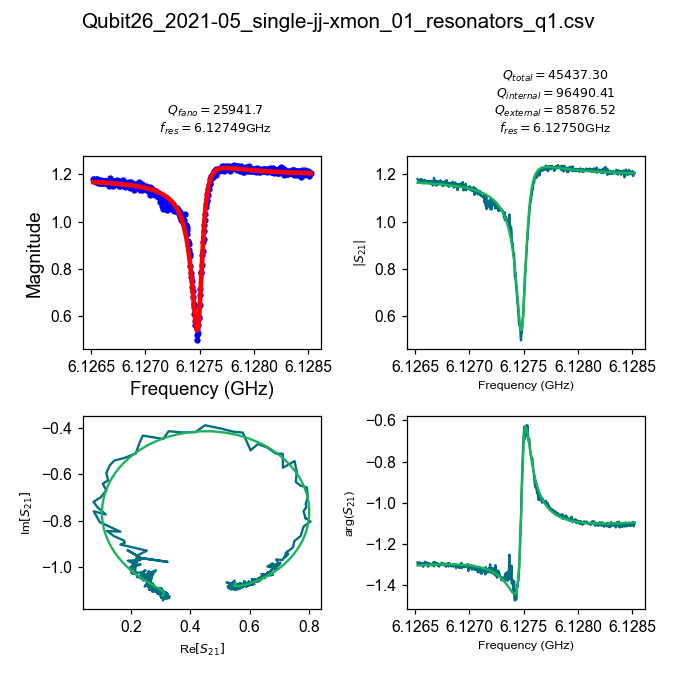

In [4]:
#FILENAME = '/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2021-04-09_single-jj-xmon/Qubit26_2021-04-09_single-jj-xmon_01_resonators_q1.txt'
FILENAME = "C:/ExperimentBlue/Qubit26_2021-05_single_jj_xmon/Qubit26_2021-05_single-jj-xmon_01_resonators_q1.csv"
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.128*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png").replace("csv", "png"))

<IPython.core.display.Javascript object>


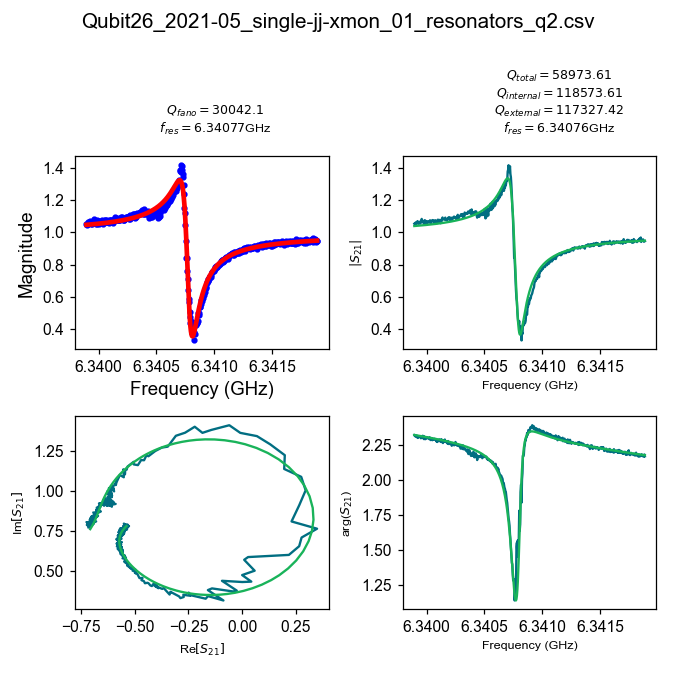

In [8]:
FILENAME = "C:/ExperimentBlue/Qubit26_2021-05_single_jj_xmon/Qubit26_2021-05_single-jj-xmon_01_resonators_q2.csv"
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.34*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png").replace("csv", "png"))

<IPython.core.display.Javascript object>


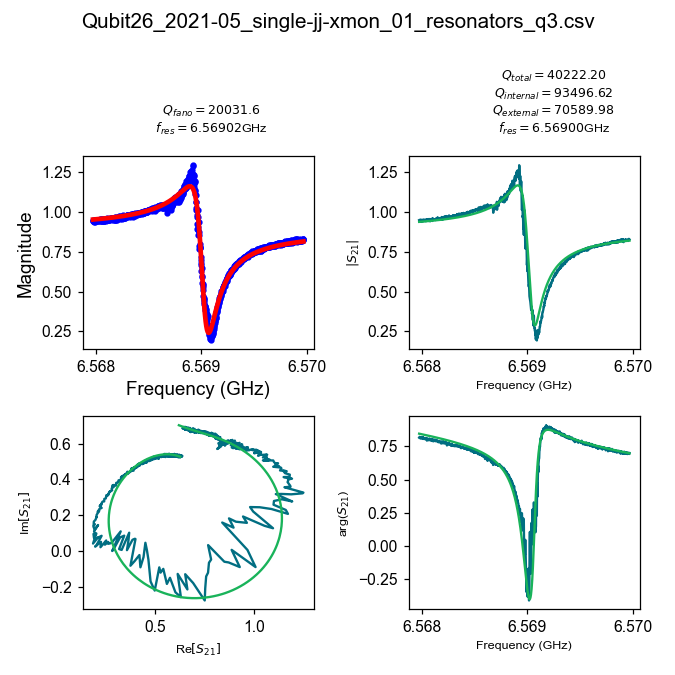

In [7]:
FILENAME = "C:/ExperimentBlue/Qubit26_2021-05_single_jj_xmon/Qubit26_2021-05_single-jj-xmon_01_resonators_q3.csv"
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.56*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png").replace("csv", "png"))

Failed fano fit!


<IPython.core.display.Javascript object>


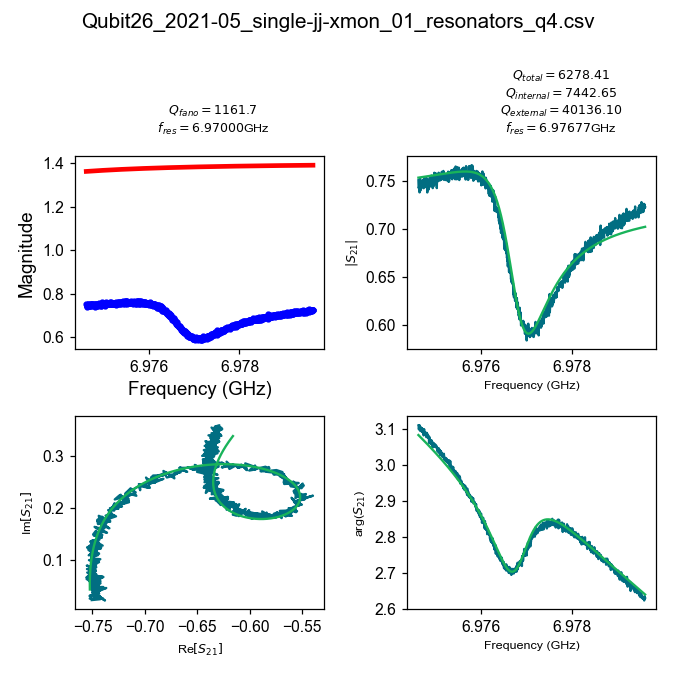

In [10]:
FILENAME = "C:/ExperimentBlue/Qubit26_2021-05_single_jj_xmon/Qubit26_2021-05_single-jj-xmon_01_resonators_q4.csv"
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        6.97*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png").replace("csv", "png"))

<IPython.core.display.Javascript object>


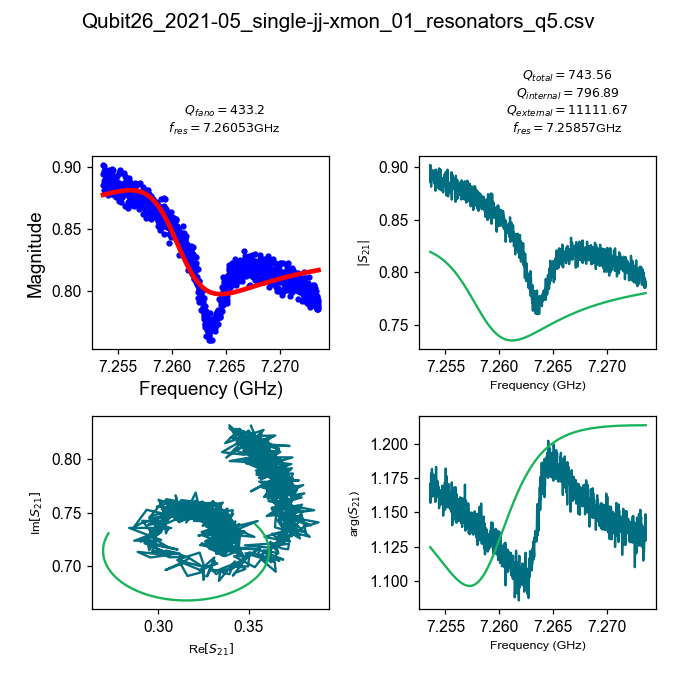

In [12]:
FILENAME = "C:/ExperimentBlue/Qubit26_2021-05_single_jj_xmon/Qubit26_2021-05_single-jj-xmon_01_resonators_q5.csv"
df = pd.read_csv(FILENAME,sep='\t')
df.columns = ["freq", "mag", "phase"]

resonator_evaluator(
    df,
    [
        7.25*GHz, 
        1, 
        0.4, 
        0, 
        3*MHz],
        FILENAME.split("/")[-1]
)

plt.savefig(FILENAME.replace("txt", "png").replace("csv", "png"))

# Qubit Spectrum
- There is no magnetic field dependence, as it is a single JJ
- There will be a stark shift as a results of qubit-resonator interaction

\begin{equation}
 \def\blue#1{\color{blue}{#1}}
  \mathcal{H}                       =\color{blue}{-\frac{\Delta
      E}{2}\sigma_z}+\blue{{\hbar\omega_r}a^\dagger     a}      +     \red{\hbar
    g_0\bigg({a\sigma^+}+{a^{\dagger}\sigma^-}\bigg)},
\end{equation}

# Rabi

In [38]:
def rabi_model(t, tDec, T, A, B, C, D, *args):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.exp(-t / tDec) + C*t + D

def rabi_model_beating(t, t_dec, T, A, B, C, D, E, t_beat):
    """
    OLD! Need to move t_beat to the end!
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B)sin(2π t / t_beat + E) + Ct + D
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.sin(2 * np.pi * t / t_beat + E) *  np.exp(-t / t_dec) + C*t + D

## Qubit26_2021-05_single-jj-xmon_05_rabi-sweep-q2_VNA(-35)_GEN(10).vi

In [50]:
RABI_MODEL = rabi_model_beating
# FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2021-05-05_single-jj-xmon/Qubit26_2021-05_single-jj-xmon_04_rabi-sweep-q2_VNA(-25)_GEN(10)_amplitude.txt"
FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2021-05-05_single-jj-xmon/Qubit26_2021-05_single-jj-xmon_05_rabi-sweep-q2_VNA(-35)_GEN(10)_amplitude.txt"

with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    

T_DATA = np.linspace(*y_range)
F_DATA = np.linspace(*f_range)
try:
    # Load in default fit values for this file
    with open(f"data/cache/{os.path.basename(FILENAME)}.cache") as fin:
        fit_data = {int(k): v for k, v in json.load(fin).items()}
    print("Loaded cached parameters!")
except:
    fit_data = {}

<IPython.core.display.Javascript object>


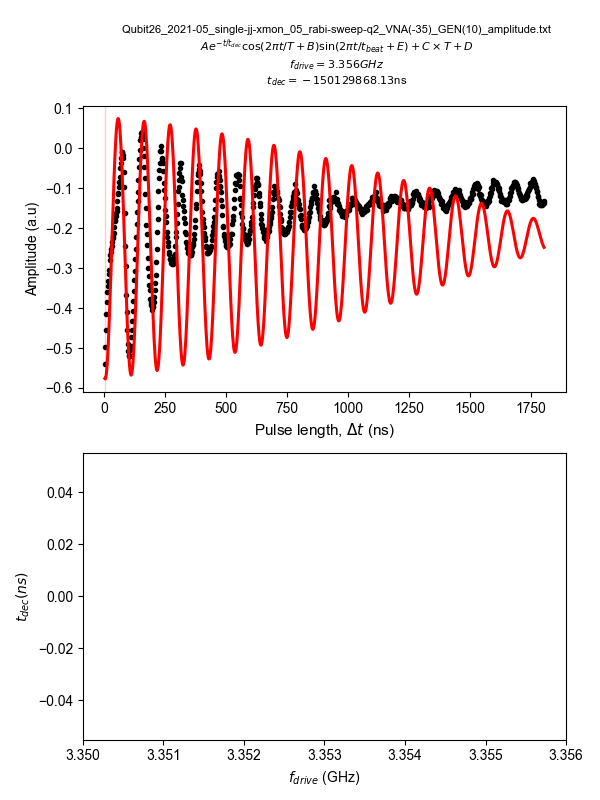

In [56]:
# Initial Guess
cut = (0, 1)
INDEX = 2
t_dec = 5328.30
T = 123.5
t_beat = 8000
A = 0.5
B = 4.44
C = (-10**(-6) * 16.5)
D = -0.25
E = np.pi / 2

# Fitting
y_data = DATA[INDEX]
try:
    (popt, _) = curve_fit(
        RABI_MODEL,
        np.delete(T_DATA, np.arange(cut[0], cut[1])),
        np.delete(y_data, np.arange(cut[0], cut[1])),
        [t_dec, T, A, B, C, D, E, t_beat]
    )
except RuntimeError:
    popt = (t_dec, T, A, B, C, D, E, t_beat)

# Plotting
fix, ax = plt.subplots(2, 1, figsize=(6, 8))
raw, = ax[0].plot(T_DATA, y_data, color="black", marker=".", linestyle='')
fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, *popt), color="blue")
user_fitting, = ax[0].plot(T_DATA, RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat), color="red", linewidth=2.2)
ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)
ax[0].set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax[0].set_ylabel("Amplitude (a.u)", fontsize=10)
ax[0].set_title(f"""
    {FILENAME.split("/")[-1]}
     $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
    $f_{{drive}} = {F_DATA[INDEX]/GHz}GHz$ 
    $t_{{dec}} = {popt[0]:.2f}$ns
    """, fontsize=8)

ax[1].set_xlabel("$f_{drive}$ (GHz)", fontsize=10)
ax[1].set_ylabel("$t_{dec} (ns)$", fontsize=10)
ax[1].set_xlim(f_range[0]/GHz, f_range[1]/GHz)
param_plot, = ax[1].plot([], [], marker="o", linestyle='')
plt.tight_layout()

# Interactivity
def update(t_dec, T, t_beat, A, B, C, D, E, 
           cut, INDEX, user_toggle, fit_toggle):
    C = C / 10**6
    y_data = DATA[INDEX]
    try:
        (popt, _) = curve_fit(
            RABI_MODEL,
            np.delete(T_DATA, np.arange(cut[0], cut[1])),
            np.delete(y_data, np.arange(cut[0], cut[1])),
            [t_dec, T, A, B, C, D, E, t_beat]
        )
    except RuntimeError:
        print("Failed regression!")
        popt = (t_dec, T, A, B, C, D, E, t_beat)
    ax[0].set_title(f"""
        {FILENAME.split("/")[-1]}
        $Ae^{{-t/t_{{dec}}}} \cos(2\pi{{t}}/T + B) \sin(2\pi{{t}}/t_{{beat}} + E) + C\\times{{T}} + D$
        $f_{{drive}} = {F_DATA[INDEX]/GHz}GHz$ 
        $t_{{dec}} = {popt[0]:.2f}$ns
        """, fontsize=8)
    fitting.set_ydata(RABI_MODEL(T_DATA, *popt))
    raw.set_ydata(y_data)
    user_fitting.set_ydata(RABI_MODEL(T_DATA, t_dec, T, A, B, C, D, E, t_beat))
    ax[0].patches = []
    ax[0].axvspan(T_DATA[cut[0]], T_DATA[cut[1]], color='red', alpha=0.2)

    user_fitting.set_visible(user_toggle)
    fitting.set_visible(fit_toggle)
    ax[0].relim()
    ax[0].autoscale_view()
    return popt

def store_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = list(update(
        t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value, 
        D_widget.value, E_widget.value, CUT_widget.value, 
        INDEX,  user_toggle_widget.value,  fit_toggle_widget.value))

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def store_user_fit(_):
    INDEX = INDEX_widget.value

    fit_data[INDEX] = (t_dec_widget.value, T_widget.value, t_beat_widget.value, A_widget.value, B_widget.value, C_widget.value/10**6, 
        D_widget.value, E_widget.value)

    unpacked_fit_data = np.array([[F_DATA[k], v[0]]
                                  for k, v in fit_data.items()])
    unpacked_f = unpacked_fit_data[:, 0]/GHz
    unpacked_t_dec = unpacked_fit_data[:, 1]

    param_plot.set_data(unpacked_f, unpacked_t_dec)
    ax[1].relim()
    ax[1].autoscale_view()
    print(f"Stored parameters!{fit_data}")
def dump_parameters(_):
    """Parameters saved to file so that they can be read later on"""
    INDEX = INDEX_widget.value
    save_file = f"data/cache/{os.path.basename(FILENAME)}.cache"
    with open(save_file, "w") as fout:
        json.dump(fit_data, fout)
    print(f"Parameters saved to file: '{save_file}'")
def load_parameters(_):
    """Set settings to the parameters in dictionary"""
    INDEX = INDEX_widget.value
    if INDEX in fit_data:
        print(f"Loaded parameters!: {fit_data[INDEX]}")
        t_dec_widget.value = fit_data[INDEX][0]
        T_widget.value = fit_data[INDEX][1]
        A_widget.value = fit_data[INDEX][2]
        B_widget.value = fit_data[INDEX][3]
        C_widget.value = fit_data[INDEX][4] * 10**6
        D_widget.value = fit_data[INDEX][5]
        E_widget.value = fit_data[INDEX][6]
        t_beat_widget.value = fit_data[INDEX][7]
    else:
        print("No parameters saved for this plot")

In [58]:
CONTINUOUS_UPDATE = False
t_dec_widget = ipywidgets.FloatSlider(
    min=1, max=10000,
    description="$t_{dec}$ (ns)", value=t_dec,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_dec_widget.style.handle_color = 'red'
t_beat_widget = ipywidgets.FloatSlider(
    min=1, max=10000,
    description="$t_{beat}$ (ns)", value=t_beat,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
t_beat_widget.style.handle_color = 'red'

T_widget = ipywidgets.FloatSlider(
    min=100, max=200, step=0.25,
    description="$T$ (nd)", value=T,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
T_widget.style.handle_color = 'red'

CUT_widget = ipywidgets.SelectionRangeSlider(
    options=[(i, i) for i, t in enumerate(T_DATA)],
    description='Cut points', value=cut,
    layout=ipywidgets.Layout(width='90%')
)
CUT_widget.style.handle_color = 'blue'
A_widget = ipywidgets.FloatSlider(
    min=0, max=0.5, step=0.001,
    description="A", value=A,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
B_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="B", value=B,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
C_widget = ipywidgets.FloatSlider(
    min=-20, max=20, step=0.1,
    description="C * 10^6", value=C * 10**6,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
D_widget = ipywidgets.FloatSlider(
    min=-0.5, max=0.5, step=0.001, readout_format='.3f',
    description="D", value=D,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
E_widget = ipywidgets.FloatSlider(
    min=0, max=2*np.pi, step=0.01,
    description="E", value=E,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget = ipywidgets.IntSlider(
    min=0, max=len(F_DATA) - 1,
    description="idx", value=INDEX,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
INDEX_widget.style.handle_color = 'blue'

store_fit_widget = ipywidgets.Button(
    description='Store Regression Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_fit_widget.on_click(store_fit)
store_user_fit_widget = ipywidgets.Button(
    description='Store User Parameters',
    icon='arrow-down'  # (FontAwesome names without the `fa-` prefix),
)
store_user_fit_widget.on_click(store_user_fit)
load_parameters_widget = ipywidgets.Button(
    description='Load Fit Parameters',
    icon='arrow-up',     layout=ipywidgets.Layout(width='90%'),
)
load_parameters_widget.on_click(load_parameters)
dump_widget = ipywidgets.Button(
    description='Save Parameters to file',
    icon='save', layout=ipywidgets.Layout(width='90%')
)
dump_widget.on_click(dump_parameters)
user_toggle_widget = ipywidgets.Checkbox(
    description='User Fitting',
    value=True,
    continuous_update=CONTINUOUS_UPDATE
)
fit_toggle_widget = ipywidgets.Checkbox(
    description='Regression Fitting',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(12, 4)
ui[0, :] = t_dec_widget
ui[1, :] = T_widget
ui[2, :] = t_beat_widget
ui[3, :] = A_widget
ui[4, :] = B_widget
ui[5, :] = C_widget
ui[6, :] = D_widget
ui[7, :] = E_widget
ui[8, :] = CUT_widget
ui[9, :] = INDEX_widget
ui[10, 0] = user_toggle_widget
ui[10, 1] = store_user_fit_widget
ui[10, 2] = fit_toggle_widget
ui[10, 3]= store_fit_widget
ui[11, :1] = dump_widget
ui[11, 2:] = load_parameters_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "t_dec": t_dec_widget,
        "T": T_widget,
        "t_beat": t_beat_widget,
        "A": A_widget,
        "B": B_widget,
        "C": C_widget,
        "D": D_widget,
        "E": E_widget,
        "INDEX": INDEX_widget,
        "cut": CUT_widget,
        "user_toggle": user_toggle_widget,
        "fit_toggle": fit_toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatSlider(value=5328.3, continuous_update=False, description='$t_{dec}$ (ns)', layo…

Output()

In [269]:
# Summarise the fittings:
SPACING = 0.03
cmap = plt.cm.jet(np.linspace(0, 1, len(fit_data)))

# Plot T, t_dec for different frequencies and the rabi plots
# fix, ax = plt.subplots(3, 1, figsize=(4,9))
plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(gs[:, 0])
ax0.set_title("Rabi Fits")
ax0.set_xlabel("Pulse length, $\Delta t$ (ns)", fontsize=11)
ax0.set_ylabel("Amplitude (a.u)", fontsize=10)

ax1 = plt.subplot(gs[0, 1])
ax1.set_title("$t_{dec}$")
ax1.set_xlabel("$f_{drive}$ (GHz)", fontsize=10)
ax1.set_ylabel("$t_{dec}$ (ns)", fontsize=10)

ax2 = plt.subplot(gs[1, 1])
ax2.set_title("$T$")
ax2.set_xlabel("$f_{drive}$ (GHz)", fontsize=10)
ax2.set_ylabel("$T$ (ns)", fontsize=10)

# Plot Rabi
for i, (idx, val) in enumerate(fit_data.items()):
    ax0.plot(T_DATA, i * SPACING + rabi_model_beating(T_DATA, *val), color=cmap[i])
    ax0.scatter(T_DATA, i * SPACING + data[idx], marker=',', color=cmap[i], s=1)
    
# Plot t_dec and T
unpacked_fit_data = np.array([[f_data[k], v[0], v[1]] for k, v in fit_data.items()])
unpacked_f = unpacked_fit_data[:, 0] / GHz
ax1.scatter(unpacked_f, unpacked_fit_data[:, 1], marker='o', s=20, color=cmap) 
ax2.scatter(unpacked_f, unpacked_fit_data[:, 2], marker='o', s=20, color=cmap) 

plt.tight_layout()
#plt.savefig(FILENAME.replace("txt", "pdf"))

<IPython.core.display.Javascript object>

# $T_1$

### Load data

In [3]:
FILE_NAME = "./data/2020-10-23_xmon_measurements/2020-09-17_xmon_ay_q3_t1-14.txt"
with open(FILE_NAME) as fin:
    yargs = fin.readline().strip().split()
    ymin = float(yargs[1])
    ymax = float(yargs[2])  
    xargs= fin.readline().strip().split()
    xmin = float(xargs[1])
    xmax = float(xargs[2])

FileNotFoundError: [Errno 2] No such file or directory: './data/2020-10-23_xmon_measurements/2020-09-17_xmon_ay_q3_t1-14.txt'

In [22]:
from scipy.ndimage import gaussian_filter

data = np.loadtxt(FILE_NAME)
data = gaussian_filter(data, sigma = 2)
x_num = data.shape[1]
y_num = data.shape[0]

array([-6. , -5.8, -5.6, -5.4, -5.2, -5. , -4.8, -4.6, -4.4, -4.2, -4. ])

<IPython.core.display.Javascript object>


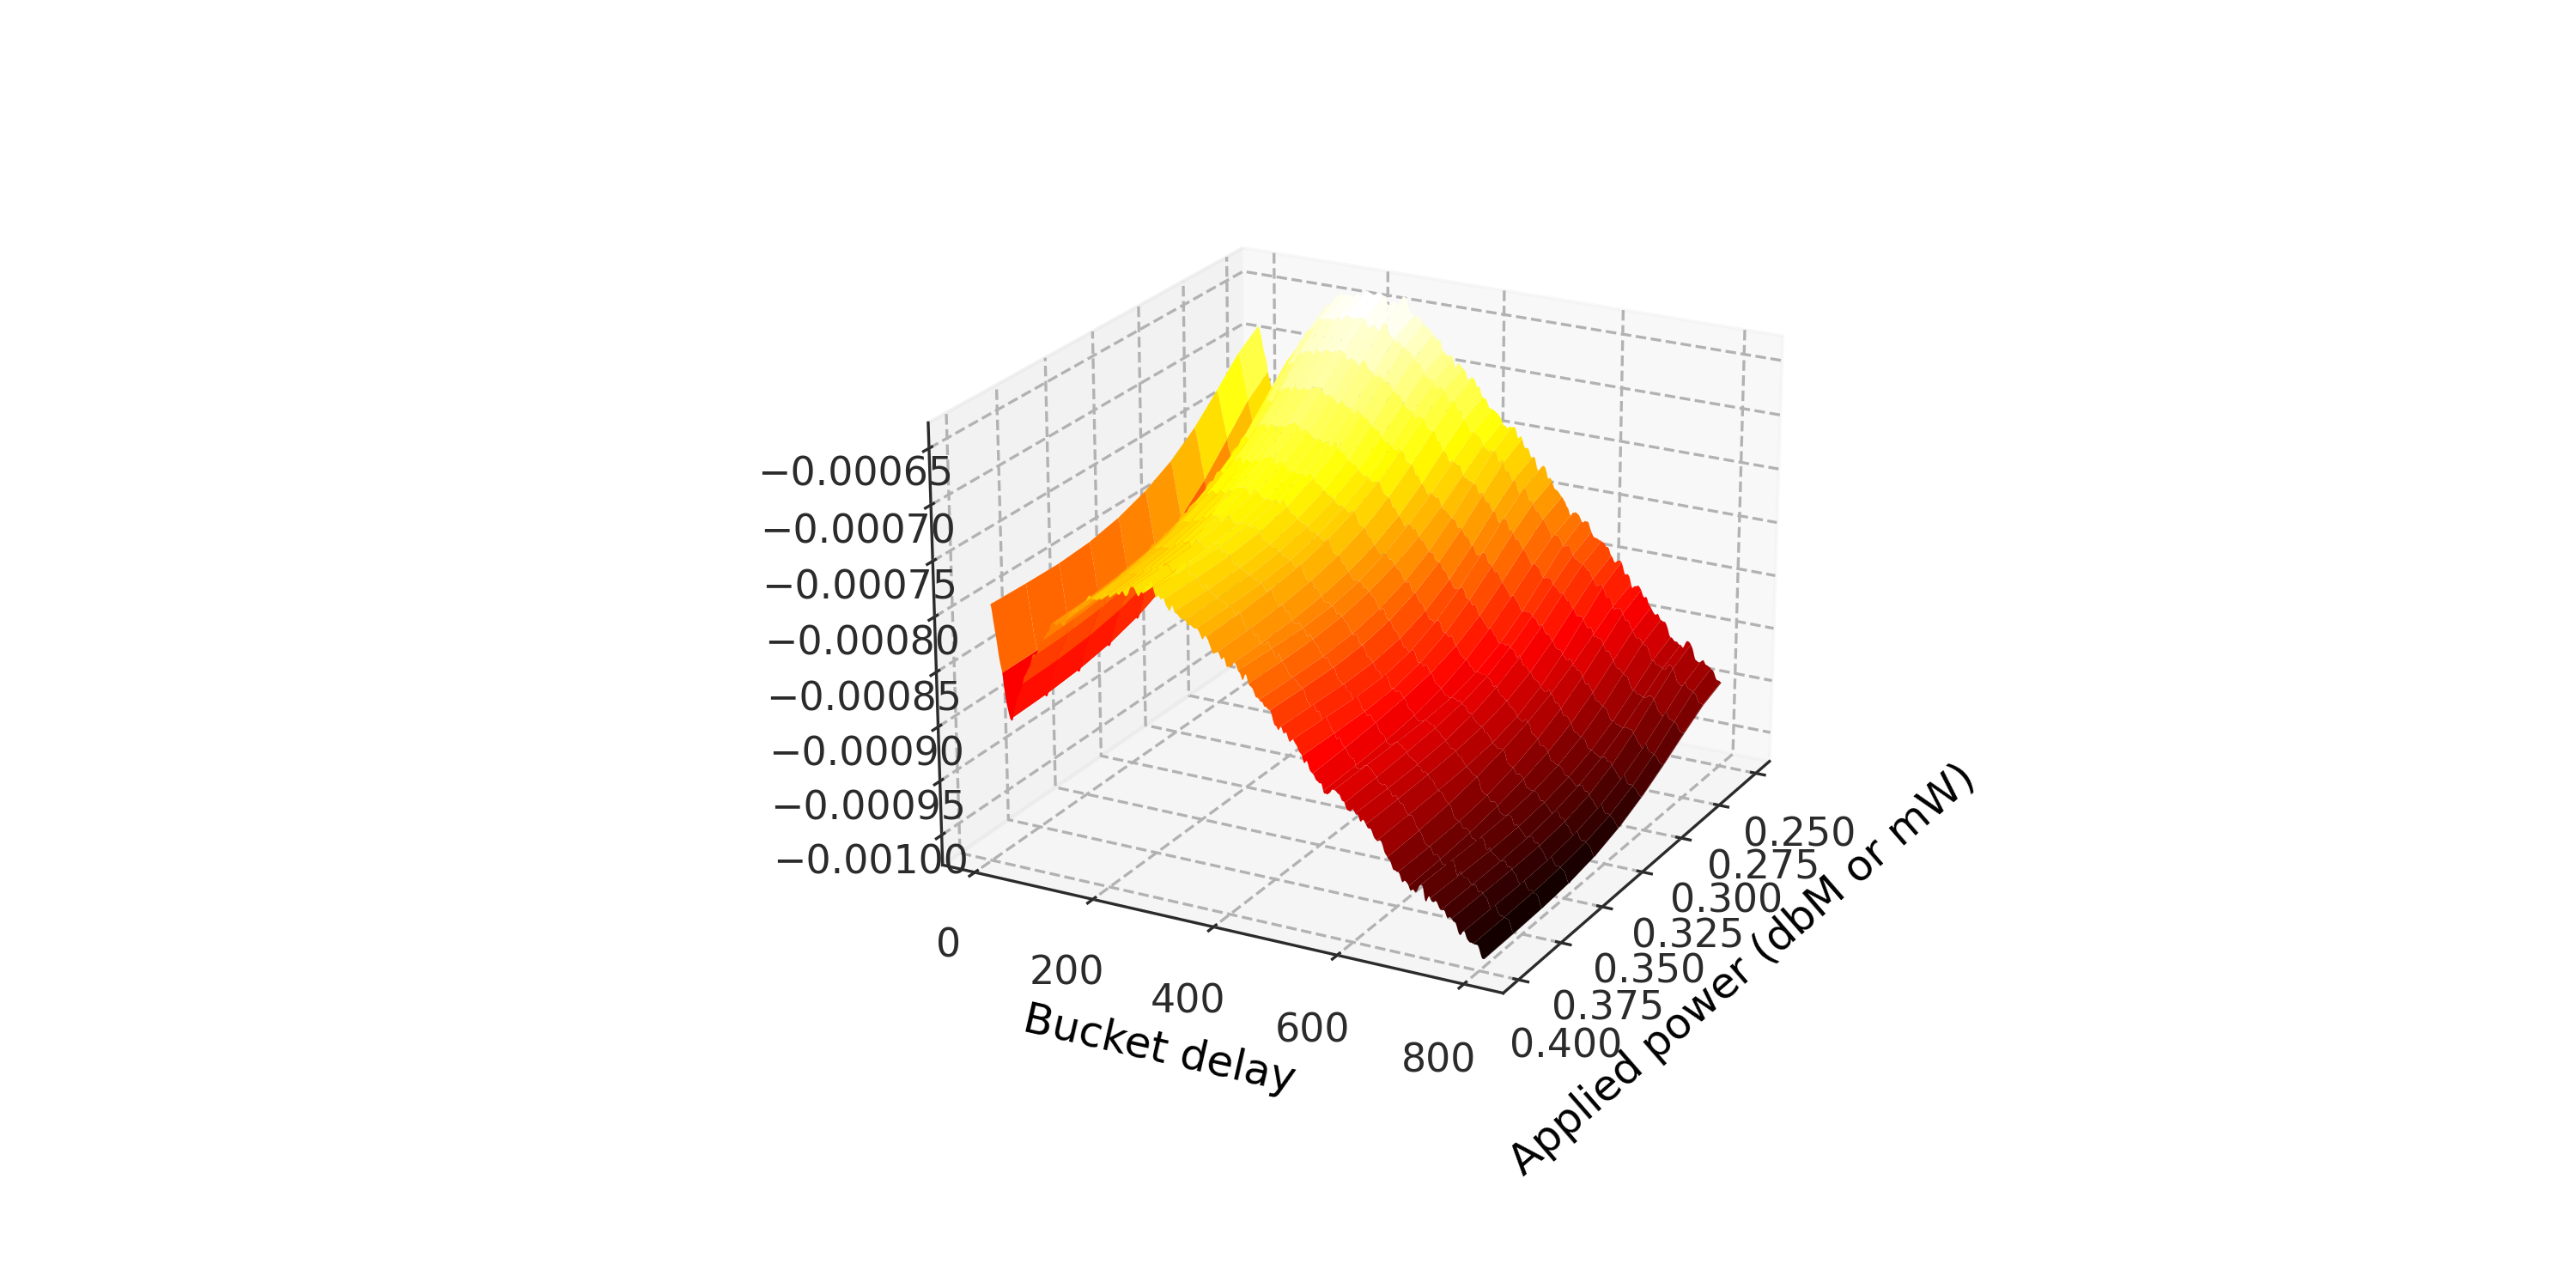

Text(0.5, 0, 'Applied power (dbM or mW)')

In [30]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

time_range = np.linspace(xmin, xmax, x_num)
power_range_in_dbm = np.linspace(ymin, ymax, y_num)
power_range_in_mW = [10**(x / 10) for x in power_range_in_dbm]

grid_x, grid_y = np.meshgrid(time_range, power_range_in_mW)
im = ax.plot_surface(
    grid_y,
    grid_x,
    data,
    cmap=cm.hot,
)
ax.set_ylabel("Bucket delay", fontsize=12)
ax.set_xlabel("Applied power (dbM or mW)", fontsize=12)